<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Grokking_Generalization_Beyond_Overfitting_on_Small_Algorithmic_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
Epoch 1/1667
Epoch 1: Training Accuracy = 0.0039, Training Loss = 4.7578, Validation Accuracy = 0.0115, Validation Loss = 4.7427
Epoch 2/1667
Epoch 2: Training Accuracy = 0.0176, Training Loss = 4.5966, Validation Accuracy = 0.0164, Validation Loss = 4.6245
Epoch 3/1667
Epoch 3: Training Accuracy = 0.0176, Training Loss = 4.5966, Validation Accuracy = 0.0164, Validation Loss = 4.6245
Epoch 4/1667
Epoch 4: Training Accuracy = 0.0332, Training Loss = 4.5177, Validation Accuracy = 0.0150, Validation Loss = 4.6192
Epoch 5/1667
Epoch 5: Training Accuracy = 0.0332, Training Loss = 4.5177, Validation Accuracy = 0.0150, Validation Loss = 4.6192
Epoch 6/1667
Epoch 6: Training Accuracy = 0.0352, Training Loss = 4.4769, Validation Accuracy = 0.0140, Validation Loss = 4.6015
Epoch 7/1667
Epoch 7: Training Accuracy = 0.0371, Training Loss = 4.3991, Validation Accuracy = 0.0137, Validation Loss = 4.6792
Epoch 8/1667
Epoch 8: Training Accuracy = 0.0371, Training Loss = 4.3991, Validation Accurac

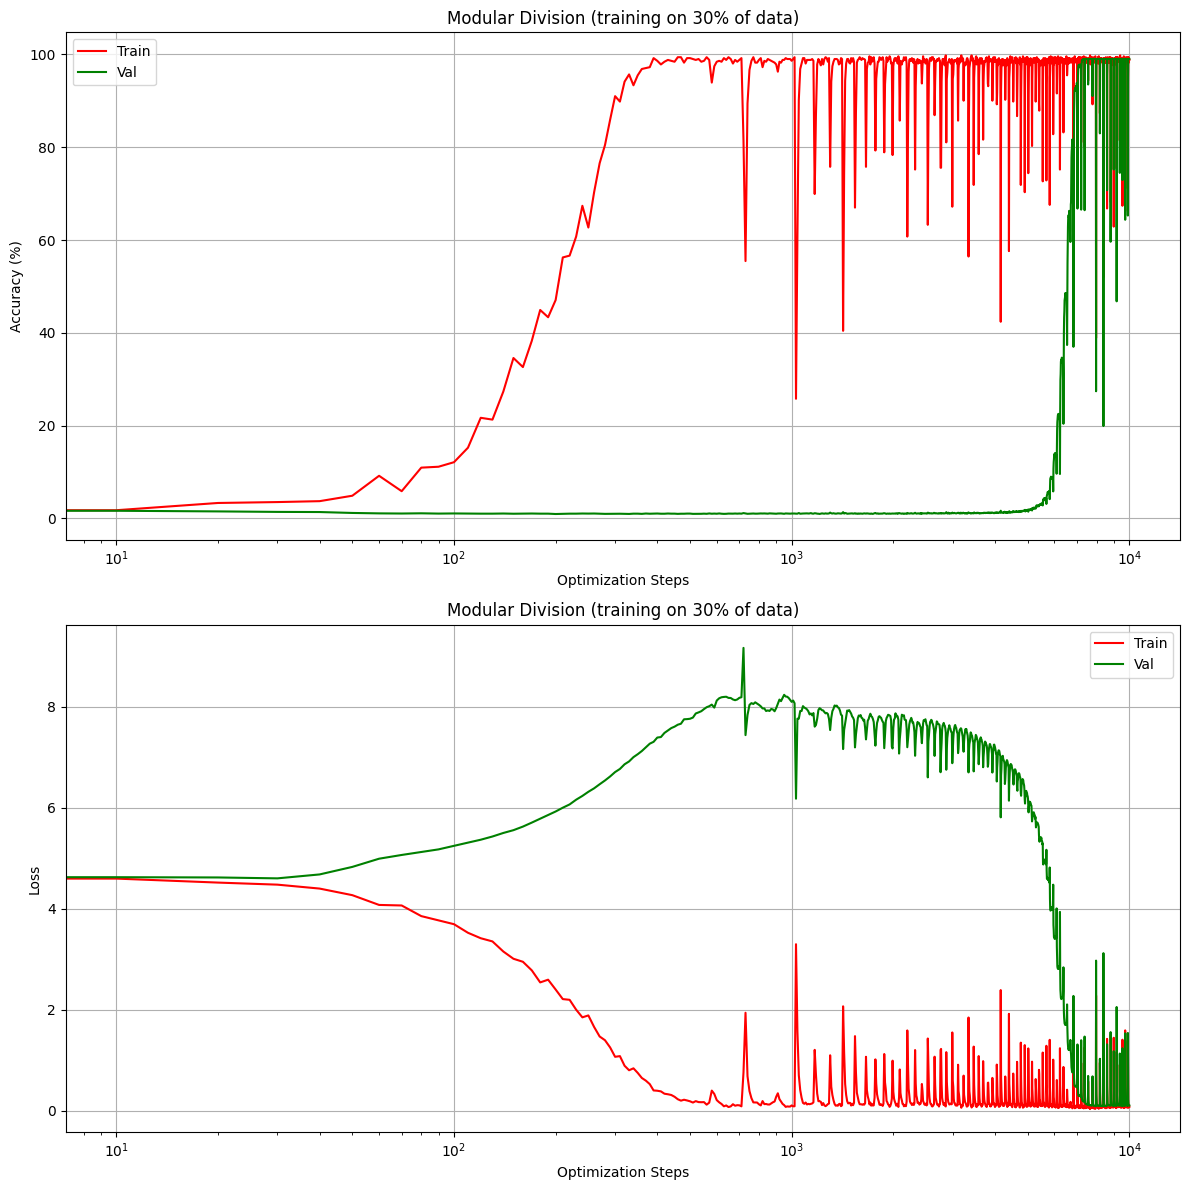

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
from einops import rearrange, repeat
from math import ceil
from tqdm import tqdm

# Define operations and data functions
DIVISION_MODULO_OPERATIONS = {
    "x/y": lambda x, y, p: (x * y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

def operation_mod_p_data(operation: str, p: int, eq_token: int, op_token: int):
    x = torch.arange(0, p)
    y = torch.arange(0 if operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

# Define the model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b=batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding

        embedding = rearrange(embedding, 'b s d -> s b d')

        return self.model(embedding)

# Training and evaluation functions
def evaluate(model, data_loader, device, metrics, step=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1, :, :]
            correct += (torch.argmax(output, dim=1) == labels).sum().item()
            total_loss += criterion(output, labels).item() * len(labels)

    accuracy = correct / len(data_loader.dataset)
    loss = total_loss / len(data_loader.dataset)

    if step is not None:
        metrics['validation/accuracy'].append((step, accuracy))
        metrics['validation/loss'].append((step, loss))
    else:
        metrics['validation/accuracy'].append(accuracy)
        metrics['validation/loss'].append(loss)

    return metrics

def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, config):
    model.train()
    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample')

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            break

    pbar.close()

    return metrics, step

# Execute the training and evaluation
# Configuration
config = {
    'operation': 'x/y',
    'training_fraction': 0.3,
    'prime': 97,
    'num_layers': 2,
    'dim_model': 128,
    'num_heads': 4,
    'batch_size': 512,
    'learning_rate': 1e-3,
    'weight_decay': 1,
    'num_steps': 10000,  # int(1e6)
    'max_epochs': int(1e8),
    'record_frequency': 10,  # Frequency of recording metrics
    'show_progress_bar': False,
    'device': 'cpu',
}

# Training and evaluation functions
def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, config):
    model.train()
    criterion = nn.CrossEntropyLoss()

    # Conditional progress bar based on config
    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample') if config.get('show_progress_bar', True) else None

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        if pbar:
            pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            break

    if pbar:
        pbar.close()

    return metrics, step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader, val_loader = get_data(
    config['operation'],
    config['prime'],
    config['training_fraction'],
    config['batch_size']
)
model = Transformer(
    num_layers=config['num_layers'],
    dim_model=config['dim_model'],
    num_heads=config['num_heads'],
    num_tokens=config['prime'] + 2,
    seq_len=5
).to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    betas=(0.9, 0.98),
    weight_decay=config['weight_decay']
)
scheduler = optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, total_iters=9
)

num_epochs = min(config['max_epochs'], ceil(config['num_steps'] / len(train_loader)))

metrics = {
    'training/accuracy': [],
    'training/loss': [],
    'validation/accuracy': [],
    'validation/loss': []
}

step = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'], config)

    # Print metrics for the current epoch in a single line
    train_acc = metrics['training/accuracy'][-1][1]
    train_loss = metrics['training/loss'][-1][1]
    val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
    val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

    print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

    # Check if max number of steps is reached
    if step >= config['num_steps']:
        print("Stopping early as maximum number of steps has been reached.")
        break

# Ensure the final step is evaluated for training metrics
metrics['training/accuracy'].append((step, train_acc))
metrics['training/loss'].append((step, train_loss))
metrics = evaluate(model, val_loader, device, metrics, step)

# Plot metrics
training_steps, training_accuracy = zip(*metrics['training/accuracy'])
training_steps, training_loss = zip(*metrics['training/loss'])
val_steps, validation_accuracy = zip(*metrics['validation/accuracy'])
val_steps, validation_loss = zip(*metrics['validation/loss'])

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.semilogx(training_steps, [acc * 100 for acc in training_accuracy], color='red', label='Train')
plt.semilogx(val_steps, [acc * 100 for acc in validation_accuracy], color='green', label='Val')
plt.xlabel('Optimization Steps')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(training_steps, training_loss, color='red', label='Train')
plt.semilogx(val_steps, validation_loss, color='green', label='Val')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.tight_layout()
plt.show()

# バッチサイズを大きく

ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 835: Training Accuracy = 0.9746, Training Loss = 0.4070, Validation Accuracy = 0.0181, Validation Loss = 6.0677
Epoch 836/3334
Epoch 836: Training Accuracy = 0.9746, Training Loss = 0.4070, Validation Accuracy = 0.0181, Validation Loss = 6.0677
Epoch 837/3334
Epoch 837: Training Accuracy = 0.9845, Training Loss = 0.2359, Validation Accuracy = 0.0178, Validation Loss = 6.4284
Epoch 838/3334
Epoch 838: Training Accuracy = 0.9845, Training Loss = 0.2359, Validation Accuracy = 0.0178, Validation Loss = 6.4284
Epoch 839/3334
Epoch 839: Training Accuracy = 0.9845, Training Loss = 0.2359, Validation Accuracy = 0.0178, Validation Loss = 6.4284
Epoch 840/3334
Epoch 840: Training Accuracy = 0.9845, Training Loss = 0.2359, Validation Accuracy = 0.0178, Validation Loss = 6.4284
Epoch 841/3334
Epoch 841: Training Accuracy = 0.9922, Training Loss = 0.1266, Validation Accuracy = 0.0179, Validation Loss = 6.4794
Epoch 842/3334
Epoch 842: Training Accuracy = 0.9922

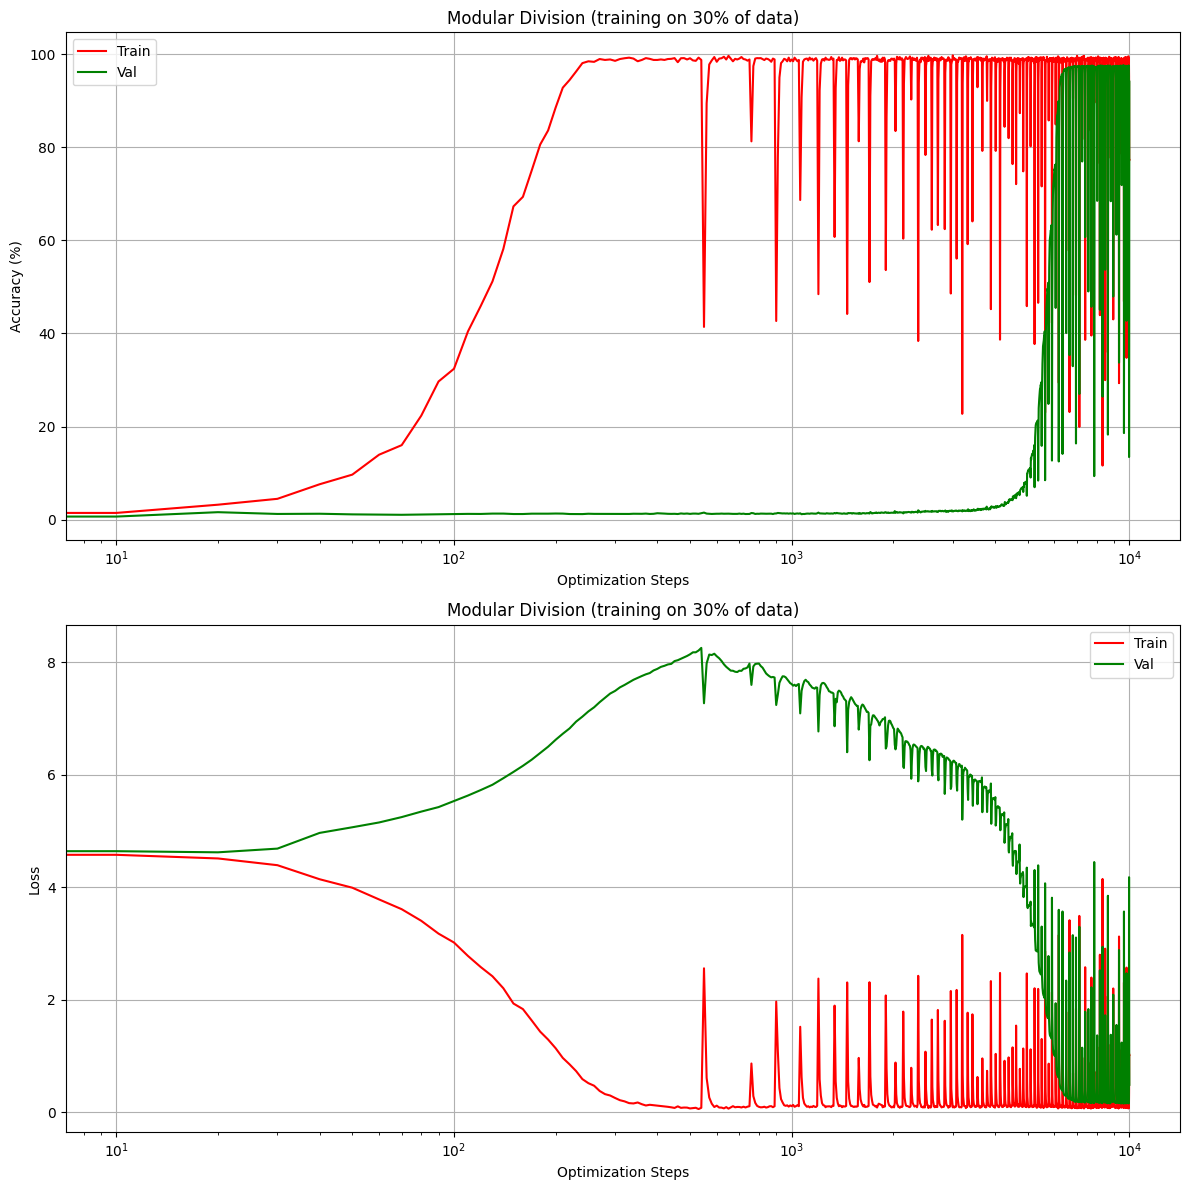

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
from einops import rearrange, repeat
from math import ceil
from tqdm import tqdm

# Define operations and data functions
DIVISION_MODULO_OPERATIONS = {
    "x/y": lambda x, y, p: (x * y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

def operation_mod_p_data(operation: str, p: int, eq_token: int, op_token: int):
    x = torch.arange(0, p)
    y = torch.arange(0 if operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

# Define the model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b=batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding

        embedding = rearrange(embedding, 'b s d -> s b d')

        return self.model(embedding)

# Training and evaluation functions
def evaluate(model, data_loader, device, metrics, step=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1, :, :]
            correct += (torch.argmax(output, dim=1) == labels).sum().item()
            total_loss += criterion(output, labels).item() * len(labels)

    accuracy = correct / len(data_loader.dataset)
    loss = total_loss / len(data_loader.dataset)

    if step is not None:
        metrics['validation/accuracy'].append((step, accuracy))
        metrics['validation/loss'].append((step, loss))
    else:
        metrics['validation/accuracy'].append(accuracy)
        metrics['validation/loss'].append(loss)

    return metrics

def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, config):
    model.train()
    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample')

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            break

    pbar.close()

    return metrics, step

# Execute the training and evaluation
# Configuration
config = {
    'operation': 'x/y',
    'training_fraction': 0.3,
    'prime': 97,
    'num_layers': 2,
    'dim_model': 128,
    'num_heads': 4,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'weight_decay': 1,
    'num_steps': 10000,  # int(1e6)
    'max_epochs': int(1e8),
    'record_frequency': 10,  # Frequency of recording metrics
    'show_progress_bar': False,
    'device': 'cpu',
}

# Training and evaluation functions
def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, config):
    model.train()
    criterion = nn.CrossEntropyLoss()

    # Conditional progress bar based on config
    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample') if config.get('show_progress_bar', True) else None

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        if pbar:
            pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            break

    if pbar:
        pbar.close()

    return metrics, step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader, val_loader = get_data(
    config['operation'],
    config['prime'],
    config['training_fraction'],
    config['batch_size']
)
model = Transformer(
    num_layers=config['num_layers'],
    dim_model=config['dim_model'],
    num_heads=config['num_heads'],
    num_tokens=config['prime'] + 2,
    seq_len=5
).to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    betas=(0.9, 0.98),
    weight_decay=config['weight_decay']
)
scheduler = optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, total_iters=9
)

num_epochs = min(config['max_epochs'], ceil(config['num_steps'] / len(train_loader)))

metrics = {
    'training/accuracy': [],
    'training/loss': [],
    'validation/accuracy': [],
    'validation/loss': []
}

step = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'], config)

    # Print metrics for the current epoch in a single line
    train_acc = metrics['training/accuracy'][-1][1]
    train_loss = metrics['training/loss'][-1][1]
    val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
    val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

    print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

    # Check if max number of steps is reached
    if step >= config['num_steps']:
        print("Stopping early as maximum number of steps has been reached.")
        break

# Ensure the final step is evaluated for training metrics
metrics['training/accuracy'].append((step, train_acc))
metrics['training/loss'].append((step, train_loss))
metrics = evaluate(model, val_loader, device, metrics, step)

# Plot metrics
training_steps, training_accuracy = zip(*metrics['training/accuracy'])
training_steps, training_loss = zip(*metrics['training/loss'])
val_steps, validation_accuracy = zip(*metrics['validation/accuracy'])
val_steps, validation_loss = zip(*metrics['validation/loss'])

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.semilogx(training_steps, [acc * 100 for acc in training_accuracy], color='red', label='Train')
plt.semilogx(val_steps, [acc * 100 for acc in validation_accuracy], color='green', label='Val')
plt.xlabel('Optimization Steps')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(training_steps, training_loss, color='red', label='Train')
plt.semilogx(val_steps, validation_loss, color='green', label='Val')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 学習率を小さく

ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 1: Training Accuracy = 0.0098, Training Loss = 4.8054, Validation Accuracy = 0.0096, Validation Loss = 4.7855
Epoch 2/2500
Epoch 2: Training Accuracy = 0.0215, Training Loss = 4.6142, Validation Accuracy = 0.0170, Validation Loss = 4.6339
Epoch 3/2500
Epoch 3: Training Accuracy = 0.0215, Training Loss = 4.6142, Validation Accuracy = 0.0170, Validation Loss = 4.6339
Epoch 4/2500
Epoch 4: Training Accuracy = 0.0410, Training Loss = 4.5575, Validation Accuracy = 0.0178, Validation Loss = 4.6135
Epoch 5/2500
Epoch 5: Training Accuracy = 0.0410, Training Loss = 4.5575, Validation Accuracy = 0.0178, Validation Loss = 4.6135
Epoch 6/2500
Epoch 6: Training Accuracy = 0.0234, Training Loss = 4.4873, Validation Accuracy = 0.0155, Validation Loss = 4.6020
Epoch 7/2500
Epoch 7: Training Accuracy = 0.0352, Training Loss = 4.4445, Validation Accuracy = 0.0140, Validation Loss = 4.6133
Epoch 8/2500
Epoch 8: Training Accuracy = 0.0352, Training Loss = 4.4445, Vali

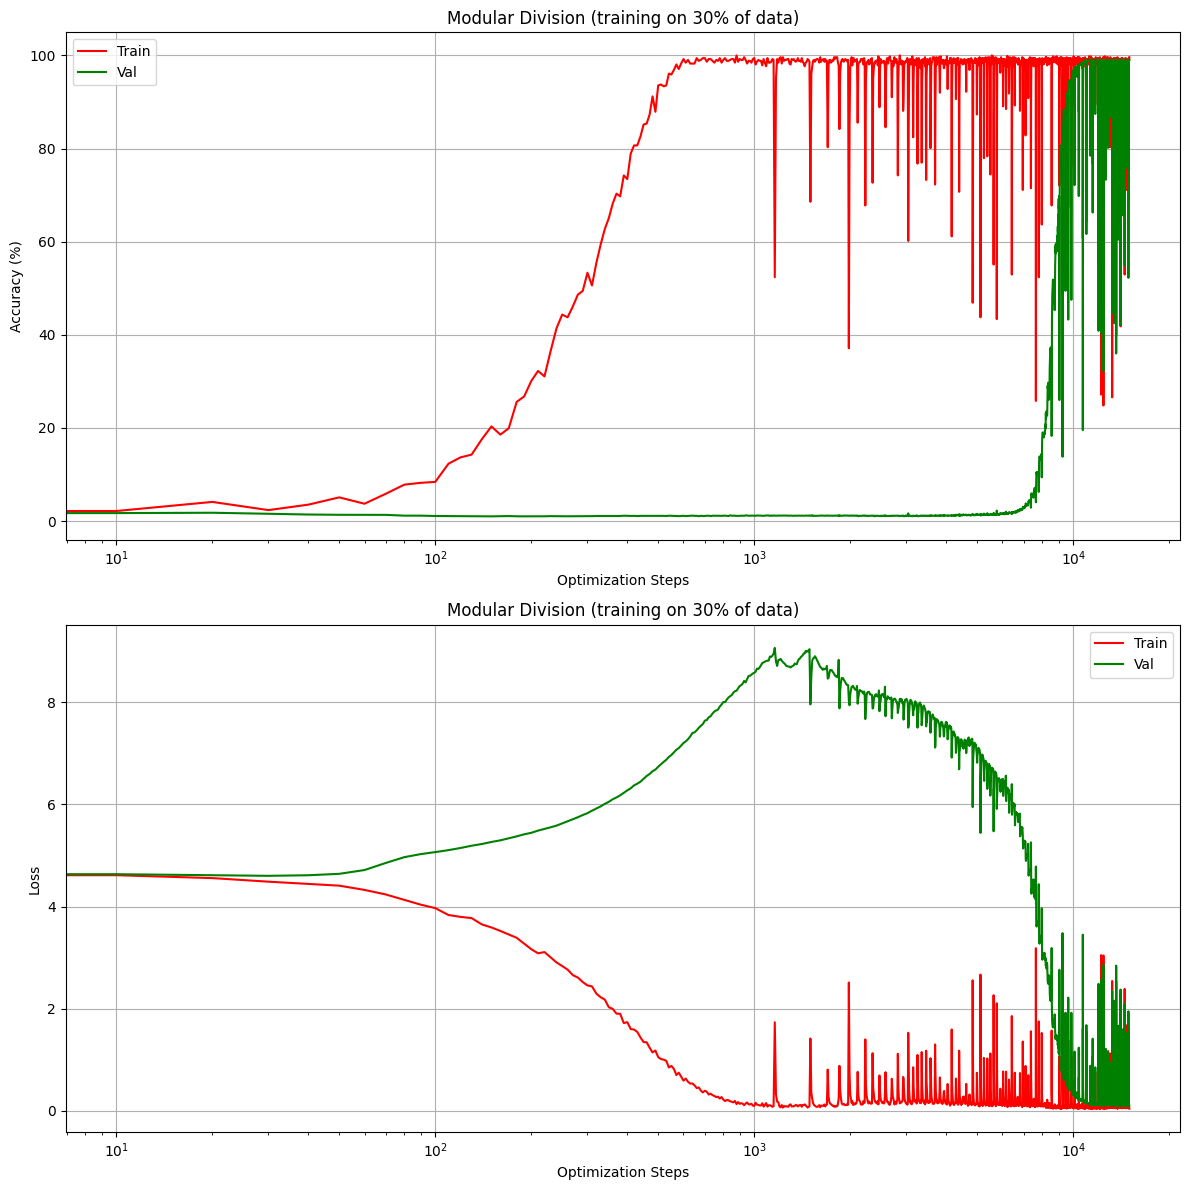

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
from einops import rearrange, repeat
from math import ceil
from tqdm import tqdm

# Define operations and data functions
DIVISION_MODULO_OPERATIONS = {
    "x/y": lambda x, y, p: (x * y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

def operation_mod_p_data(operation: str, p: int, eq_token: int, op_token: int):
    x = torch.arange(0, p)
    y = torch.arange(0 if operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

# Define the model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b=batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding

        embedding = rearrange(embedding, 'b s d -> s b d')

        return self.model(embedding)

# Training and evaluation functions
def evaluate(model, data_loader, device, metrics, step=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1, :, :]
            correct += (torch.argmax(output, dim=1) == labels).sum().item()
            total_loss += criterion(output, labels).item() * len(labels)

    accuracy = correct / len(data_loader.dataset)
    loss = total_loss / len(data_loader.dataset)

    if step is not None:
        metrics['validation/accuracy'].append((step, accuracy))
        metrics['validation/loss'].append((step, loss))
    else:
        metrics['validation/accuracy'].append(accuracy)
        metrics['validation/loss'].append(loss)

    return metrics

def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, config):
    model.train()
    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample')

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            break

    pbar.close()

    return metrics, step

# Execute the training and evaluation
# Configuration
config = {
    'operation': 'x/y',
    'training_fraction': 0.3,
    'prime': 97,
    'num_layers': 2,
    'dim_model': 128,
    'num_heads': 4,
    'batch_size': 512,
    'learning_rate': 0.0005,
    'weight_decay': 1,
    'num_steps': 15000,  # int(1e6)
    'max_epochs': int(1e8),
    'record_frequency': 10,  # Frequency of recording metrics
    'show_progress_bar': False,
    'device': 'cpu',
}

# Training and evaluation functions
def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, config):
    model.train()
    criterion = nn.CrossEntropyLoss()

    # Conditional progress bar based on config
    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample') if config.get('show_progress_bar', True) else None

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        if pbar:
            pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            break

    if pbar:
        pbar.close()

    return metrics, step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader, val_loader = get_data(
    config['operation'],
    config['prime'],
    config['training_fraction'],
    config['batch_size']
)
model = Transformer(
    num_layers=config['num_layers'],
    dim_model=config['dim_model'],
    num_heads=config['num_heads'],
    num_tokens=config['prime'] + 2,
    seq_len=5
).to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    betas=(0.9, 0.98),
    weight_decay=config['weight_decay']
)
scheduler = optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, total_iters=9
)

num_epochs = min(config['max_epochs'], ceil(config['num_steps'] / len(train_loader)))

metrics = {
    'training/accuracy': [],
    'training/loss': [],
    'validation/accuracy': [],
    'validation/loss': []
}

step = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'], config)

    # Print metrics for the current epoch in a single line
    train_acc = metrics['training/accuracy'][-1][1]
    train_loss = metrics['training/loss'][-1][1]
    val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
    val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

    print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

    # Check if max number of steps is reached
    if step >= config['num_steps']:
        print("Stopping early as maximum number of steps has been reached.")
        break

# Ensure the final step is evaluated for training metrics
metrics['training/accuracy'].append((step, train_acc))
metrics['training/loss'].append((step, train_loss))
metrics = evaluate(model, val_loader, device, metrics, step)

# Plot metrics
training_steps, training_accuracy = zip(*metrics['training/accuracy'])
training_steps, training_loss = zip(*metrics['training/loss'])
val_steps, validation_accuracy = zip(*metrics['validation/accuracy'])
val_steps, validation_loss = zip(*metrics['validation/loss'])

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.semilogx(training_steps, [acc * 100 for acc in training_accuracy], color='red', label='Train')
plt.semilogx(val_steps, [acc * 100 for acc in validation_accuracy], color='green', label='Val')
plt.xlabel('Optimization Steps')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(training_steps, training_loss, color='red', label='Train')
plt.semilogx(val_steps, validation_loss, color='green', label='Val')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 5回の結果を平均

ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 835: Training Accuracy = 0.9961, Training Loss = 0.1525, Validation Accuracy = 0.0147, Validation Loss = 7.3906
Epoch 836/3334
Epoch 836: Training Accuracy = 0.9863, Training Loss = 0.1580, Validation Accuracy = 0.0134, Validation Loss = 7.4245
Epoch 837/3334
Epoch 837: Training Accuracy = 0.9922, Training Loss = 0.1263, Validation Accuracy = 0.0129, Validation Loss = 7.3962
Epoch 838/3334
Epoch 838: Training Accuracy = 0.9922, Training Loss = 0.1263, Validation Accuracy = 0.0129, Validation Loss = 7.3962
Epoch 839/3334
Epoch 839: Training Accuracy = 0.9980, Training Loss = 0.1021, Validation Accuracy = 0.0140, Validation Loss = 7.4108
Epoch 840/3334
Epoch 840: Training Accuracy = 0.9980, Training Loss = 0.1021, Validation Accuracy = 0.0140, Validation Loss = 7.4108
Epoch 841/3334
Epoch 841: Training Accuracy = 0.9844, Training Loss = 0.1484, Validation Accuracy = 0.0138, Validation Loss = 7.3988
Epoch 842/3334
Epoch 842: Training Accuracy = 0.9922

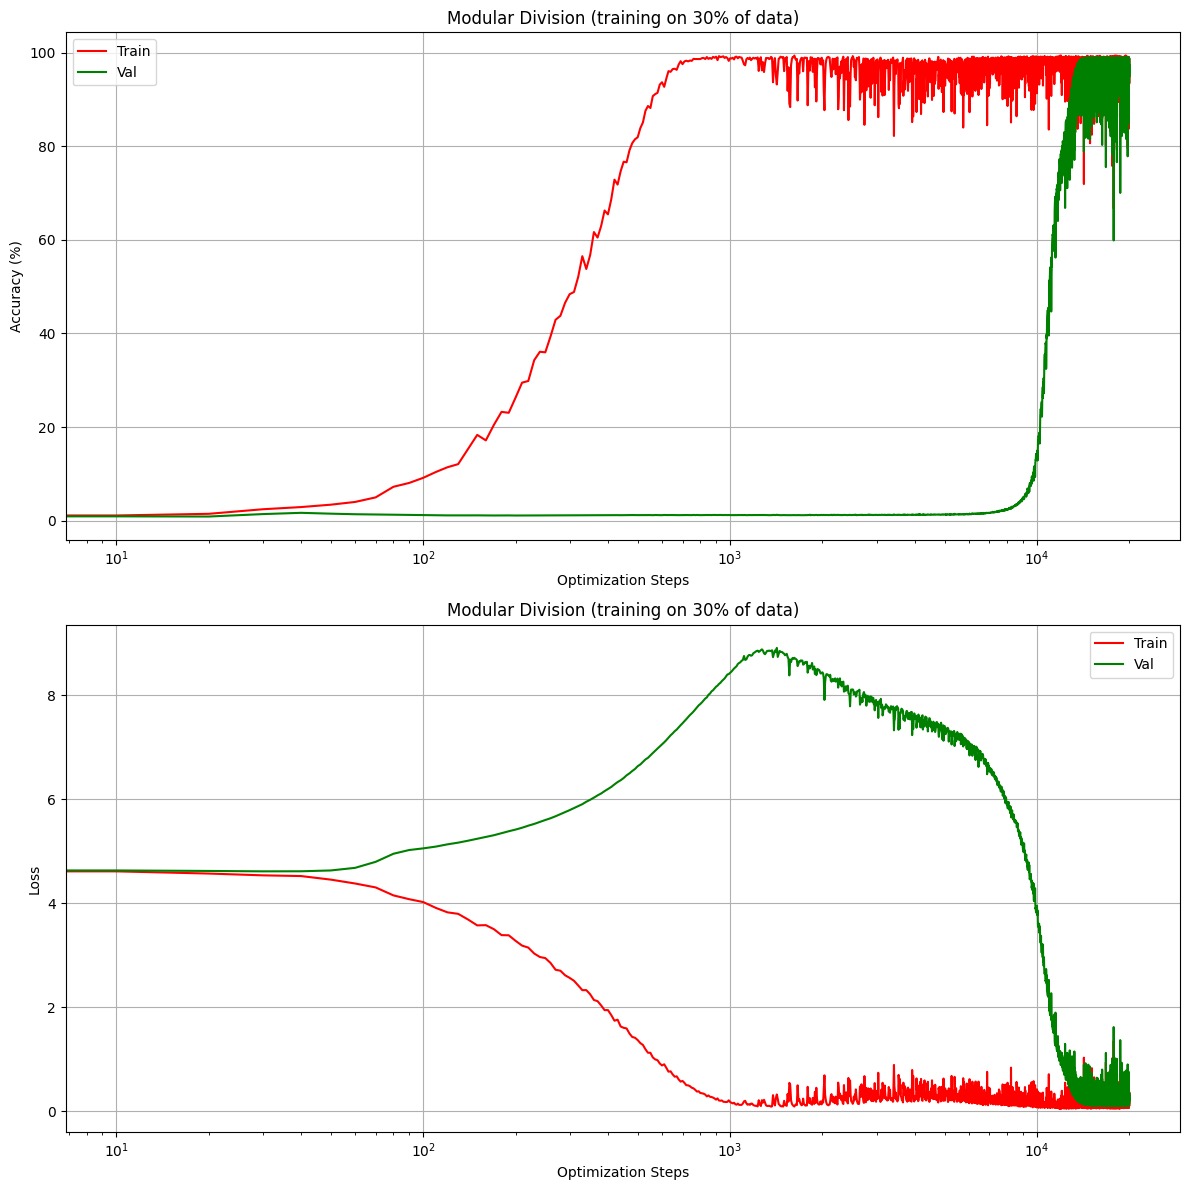

In [41]:
import numpy as np
import matplotlib.pyplot as plt

config = {
    'operation': 'x/y',
    'training_fraction': 0.3,
    'prime': 97,
    'num_layers': 2,
    'dim_model': 128,
    'num_heads': 4,
    'batch_size': 512,
    'learning_rate': 0.0005,
    'weight_decay': 1,
    'num_steps': 20000,  # int(1e6)
    'max_epochs': int(1e8),
    'record_frequency': 10,  # Frequency of recording metrics
    'show_progress_bar': False,
    'device': 'cpu',
}

# Define a function to run a single experiment and return metrics
def run_experiment(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    train_loader, val_loader = get_data(
        config['operation'],
        config['prime'],
        config['training_fraction'],
        config['batch_size']
    )
    model = Transformer(
        num_layers=config['num_layers'],
        dim_model=config['dim_model'],
        num_heads=config['num_heads'],
        num_tokens=config['prime'] + 2,
        seq_len=5
    ).to(device)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        betas=(0.9, 0.98),
        weight_decay=config['weight_decay']
    )
    scheduler = optim.lr_scheduler.LinearLR(
        optimizer, start_factor=0.1, total_iters=9
    )

    num_epochs = min(config['max_epochs'], ceil(config['num_steps'] / len(train_loader)))

    metrics = {
        'training/accuracy': [],
        'training/loss': [],
        'validation/accuracy': [],
        'validation/loss': []
    }

    step = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'], config)

        # Print metrics for the current epoch in a single line
        train_acc = metrics['training/accuracy'][-1][1]
        train_loss = metrics['training/loss'][-1][1]
        val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
        val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

        print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

        # Check if max number of steps is reached
        if step >= config['num_steps']:
            print("Stopping early as maximum number of steps has been reached.")
            break

    # Ensure the final step is evaluated for training metrics
    metrics['training/accuracy'].append((step, train_acc))
    metrics['training/loss'].append((step, train_loss))
    metrics = evaluate(model, val_loader, device, metrics, step)

    return metrics

# Number of experiments to run
num_experiments = 5

# Initialize lists to collect metrics
all_training_accuracy = []
all_training_loss = []
all_validation_accuracy = []
all_validation_loss = []

# Run experiments and collect metrics
for i in range(num_experiments):
    print(f"Running experiment {i + 1}/{num_experiments}")
    metrics = run_experiment(config)

    all_training_accuracy.append(np.array([acc for _, acc in metrics['training/accuracy']]))
    all_training_loss.append(np.array([loss for _, loss in metrics['training/loss']]))
    all_validation_accuracy.append(np.array([acc for _, acc in metrics['validation/accuracy']]))
    all_validation_loss.append(np.array([loss for _, loss in metrics['validation/loss']]))

# Convert lists to numpy arrays for easier manipulation
all_training_accuracy = np.array(all_training_accuracy)
all_training_loss = np.array(all_training_loss)
all_validation_accuracy = np.array(all_validation_accuracy)
all_validation_loss = np.array(all_validation_loss)

# Calculate means
mean_train_acc = np.mean(all_training_accuracy, axis=0)
mean_train_loss = np.mean(all_training_loss, axis=0)
mean_val_acc = np.mean(all_validation_accuracy, axis=0)
mean_val_loss = np.mean(all_validation_loss, axis=0)

# Plot metrics
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.semilogx(
    [step for step, _ in metrics['training/accuracy']],
    mean_train_acc * 100,
    color='red', label='Train'
)
plt.semilogx(
    [step for step, _ in metrics['validation/accuracy']],
    mean_val_acc * 100,
    color='green', label='Val'
)
plt.xlabel('Optimization Steps')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(
    [step for step, _ in metrics['training/loss']],
    mean_train_loss,
    color='red', label='Train'
)
plt.semilogx(
    [step for step, _ in metrics['validation/loss']],
    mean_val_loss,
    color='green', label='Val'
)
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')
plt.grid(True)

plt.tight_layout()
plt.show()